In [ ]:
# !nvidia-smi
# !pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121



^C


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 2.4 MB/s eta 0:16:59
     ---------------------------------------- 0.0/2.4 GB 3.4 MB/s eta 0:12:09
     ---------------------------------------- 0.0/2.4 GB 3.2 MB/s eta 0:12:51
     ---------------------------------------- 0.0/2.4 GB 3.2 MB/s eta 0:12:42
     ---------------------------------------- 0.0/2.4 GB 3.0 MB/s eta 0:13:29
     ---------------------------------------- 0.0/2.4 GB 2.9 MB/s eta 0:14:02
     ---------------------------------------- 0.0/2.4 GB 2.8 MB/s eta 0:14:25
     ---------------------------------------- 0.0/2.4 GB 2.8 MB/s eta 0:14:43
     ---------------------------------------- 0.0/2.4 GB 2.8 MB/s eta 0:14:34
     ---------------------------------------- 0.0/2.4 GB 2.8 MB/s eta 0:14:28
     ---------------------------------------- 0.0/2.4 GB 2.8 MB/s eta 0:14:22
     -------

Importing part

In [21]:
!pip install kagglehub[pandas-datasets]
!pip install torch
!pip install scikit-learn
!pip install pandas
!pip install matplotlib

#use in collab to run the gpu fastly takes approx 3 to 4 min 



   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---

In [23]:
import kagglehub

path= kagglehub.dataset_download("simeondee/body-fitness-exercises-and-body-measurement-data")
print(path)



C:\Users\N Kedar Vaishnav\.cache\kagglehub\datasets\simeondee\body-fitness-exercises-and-body-measurement-data\versions\1


In [25]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)


using device: cuda


load dataset

In [5]:
import os

# List contents of the downloaded directory to find the CSV file
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV files found in the downloaded directory.")

# Assuming the first CSV file is the one we need
csv_file_path = os.path.join(path, csv_files[0])

data = pd.read_csv(csv_file_path)
data.columns = [c.strip().lower().replace(" ", "_") for c in data.columns]
print("dataset loaded successfully, shape:", data.shape)

dataset loaded successfully, shape: (15000, 21)


Encoding columns 

In [6]:
gender_enc = LabelEncoder()
exercise_enc = LabelEncoder()

data['gender'] = gender_enc.fit_transform(data['gender'])
data['exercise_type_raw'] = exercise_enc.fit_transform(data['exercise_type_raw'])
print("categorical columns encoded.")


categorical columns encoded.


feature selection and scaling

In [7]:
X = data.drop(columns=['user_id', 'exercise_type_raw'])
y = data['exercise_type_raw']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=True
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)

print("training samples:", X_train.shape[0])
print("testing samples:", X_test.shape[0])


training samples: 10500
testing samples: 4500


define model

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(exercise_enc.classes_)
model = MLP(input_dim, hidden_dim, output_dim).to(device)

print("model initialized.")


model initialized.


training setup

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


train model with early stopping

In [10]:
epochs = 100
train_loss_list = []
best_loss = np.inf
patience = 15
trigger_times = 0

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_loss_list.append(epoch_loss)
    scheduler.step(epoch_loss)

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"early stopping at epoch {epoch+1}")
            break
    
    if (epoch+1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"epoch {epoch+1}/{epochs}, loss: {epoch_loss:.4f}, lr: {current_lr}")


epoch 10/100, loss: 1.1981, lr: 0.001
epoch 20/100, loss: 0.9829, lr: 0.001
epoch 30/100, loss: 0.8606, lr: 0.001
epoch 40/100, loss: 0.7977, lr: 0.001
epoch 50/100, loss: 0.7506, lr: 0.001
epoch 60/100, loss: 0.7338, lr: 0.001
epoch 70/100, loss: 0.6854, lr: 0.001
epoch 80/100, loss: 0.6306, lr: 0.0005
epoch 90/100, loss: 0.6303, lr: 0.0005
epoch 100/100, loss: 0.6022, lr: 0.0005


evaluate accuracy

In [11]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    _, preds = torch.max(outputs, 1)
    accuracy = (preds == y_test).sum().item() / y_test.size(0)
    print(f"test accuracy: {accuracy*100:.2f}%")


test accuracy: 86.20%


sample prediction

In [12]:
sample = X_test[0].unsqueeze(0)
pred_class = torch.argmax(model(sample), 1).item()

print("predicted exercise:", exercise_enc.inverse_transform([pred_class])[0])
print("actual exercise:", exercise_enc.inverse_transform([y_test[0].item()])[0])


predicted exercise: Cycling, >20 mph, racing
actual exercise: Cycling, >20 mph, racing


plot training loss

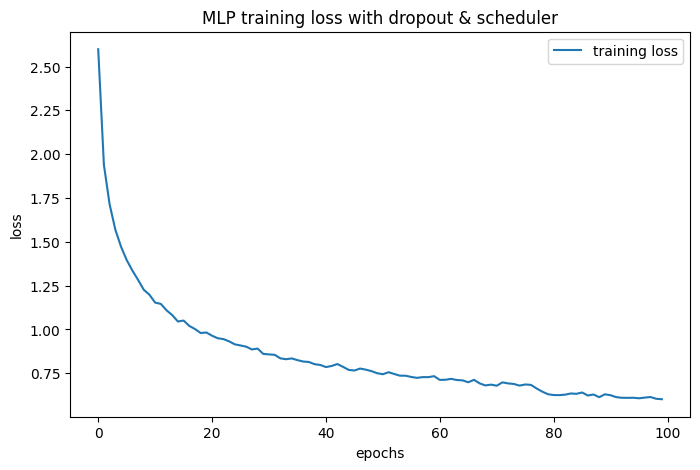

In [13]:
plt.figure(figsize=(8,5))
plt.plot(train_loss_list, label='training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('MLP training loss with dropout & scheduler')
plt.legend()
plt.show()


confusion matirx

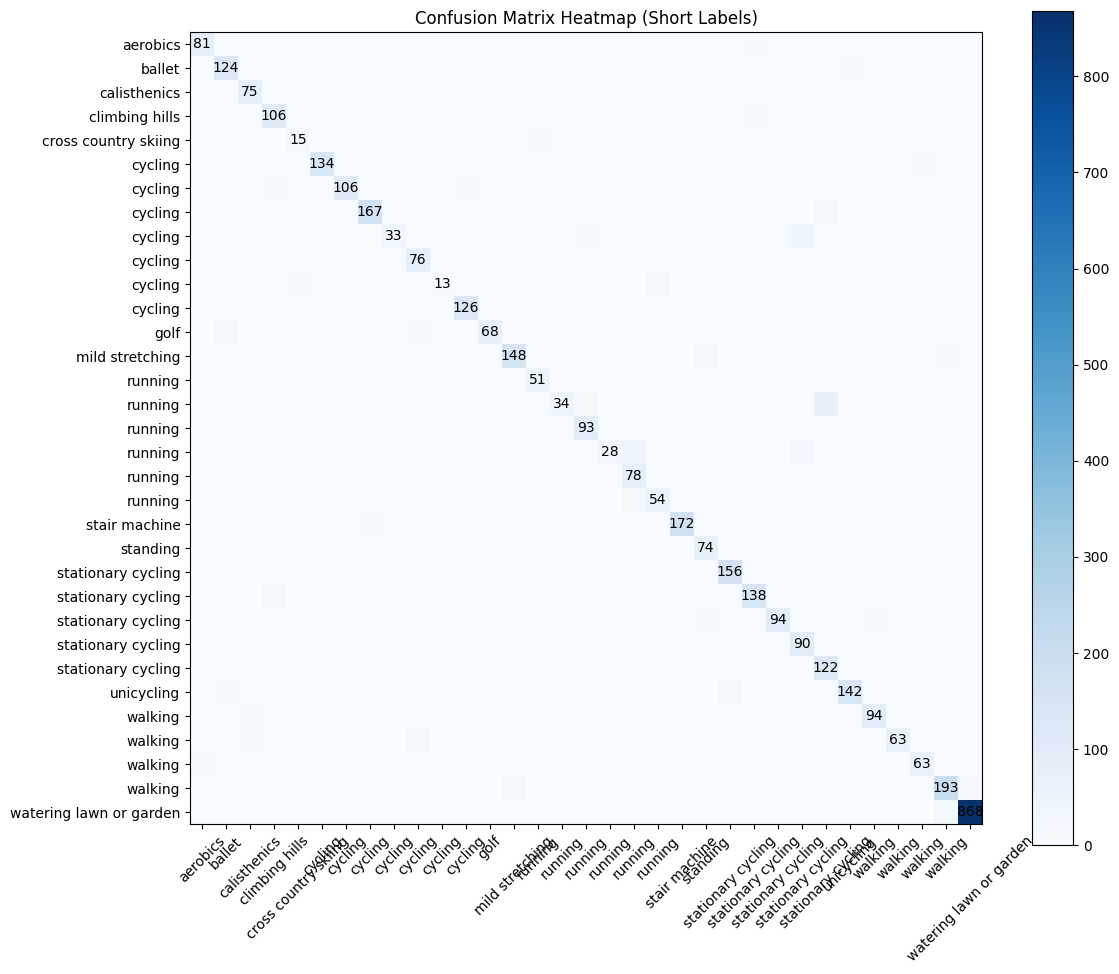


Misclassified Samples:

Sample 1:
  Predicted : Stationary cycling, vigorous
  Actual    : Cycling, 14-15.9 mph, vigorous
----------------------------------------
Sample 3:
  Predicted : Cycling, mountain bike, bmx
  Actual    : Stair machine
----------------------------------------
Sample 13:
  Predicted : Stationary cycling, vigorous
  Actual    : Cycling, 14-15.9 mph, vigorous
----------------------------------------
Sample 25:
  Predicted : Climbing hills, carrying 10 to 20 lb
  Actual    : Cycling, 12-13.9 mph, moderate
----------------------------------------
Sample 31:
  Predicted : Stationary cycling, very vigorous
  Actual    : Cycling, 16-19 mph, very fast, racing
----------------------------------------
Sample 49:
  Predicted : Walking 4.5 mph
  Actual    : Cycling, 10-11.9 mph, light
----------------------------------------
Sample 56:
  Predicted : Stationary cycling, vigorous
  Actual    : Running, 6.7 mph (9 min mile)
----------------------------------------
Sample 87:
 

In [14]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

# --- short clean exercise names ---
def clean_exercise_name(ex):
    base = re.split(r'[,\d>–-]', str(ex))[0].strip().lower()
    return base

# make short labels for classes
short_labels = [clean_exercise_name(x) for x in exercise_enc.inverse_transform(np.arange(len(exercise_enc.classes_)))]

# get predictions
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

true_labels = y_test.cpu().numpy()

# compute confusion matrix using SHORT names
cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(12, 10))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=np.arange(len(short_labels)), labels=short_labels, rotation=45)
plt.yticks(ticks=np.arange(len(short_labels)), labels=short_labels)
plt.title("Confusion Matrix Heatmap (Short Labels)")

# remove numbers
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:
            plt.text(j, i, cm[i,j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# ---- PRINT MISCLASSIFIED SAMPLES ----

print("\nMisclassified Samples:\n")

model.eval()
misclassified = []

with torch.no_grad():
    outputs = model(X_test)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    actuals = y_test.cpu().numpy()

for i, (p, a) in enumerate(zip(preds, actuals)):
    if p != a:
        misclassified.append((i, p, a))

# Display misclassified results
if len(misclassified) == 0:
    print("No misclassifications. Perfect predictions!")
else:
    for idx, pred, act in misclassified[:20]:   # print first 20 for readability
        pred_raw = exercise_enc.inverse_transform([pred])[0]
        act_raw  = exercise_enc.inverse_transform([act])[0]

        print(f"Sample {idx}:")
        print(f"  Predicted : {pred_raw}")
        print(f"  Actual    : {act_raw}")
        print("-" * 40)

    print(f"\nTotal Misclassifications: {len(misclassified)}")




In [26]:
import torch
import re

# load saved model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# --- mapping: clean exercise -> category (no codes) ---
exercise_category = {
    "aerobics": "cardio",
    "ballet": "flexibility / balance",
    "calisthenics": "strength",
    "climbing hills": "cardio",
    "cross country skiing": "cardio",
    "cycling": "cardio (lower body)",
    "golf": "light activity",
    "mild stretching": "flexibility",
    "running": "cardio (full body)",
    "stair machine": "cardio / lower body",
    "standing": "light activity",
    "stationary cycling": "cardio (lower body)",
    "unicycling": "balance / coordination",
    "walking": "light cardio",
    "watering lawn or garden": "light activity"
}

# --- helper: clean raw exercise text ---
def clean_exercise_name(ex):
    ex = str(ex)
    base = re.split(r'[,\d>–-]', ex)[0].strip().lower()
    return base

# --- number of test samples to show ---
num_samples = 5  # change as needed

# ensure model in eval mode
model.eval()

with torch.no_grad():
    outputs = model(X_test[:num_samples])
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    actuals = y_test[:num_samples].cpu().numpy()

print(f"\nshowing {num_samples} test samples:\n")

for i in range(num_samples):
    pred_raw = exercise_enc.inverse_transform([int(preds[i])])[0]
    actual_raw = exercise_enc.inverse_transform([int(actuals[i])])[0]

    pred_clean = clean_exercise_name(pred_raw)
    actual_clean = clean_exercise_name(actual_raw)

    pred_cat = exercise_category.get(pred_clean, "unknown")
    act_cat = exercise_category.get(actual_clean, "unknown")

    print(f"--- sample {i+1} ---")
    print(f"predicted exercise : {pred_raw}")
    print(f"  → cleaned name   : {pred_clean}")
    print(f"  → category       : {pred_cat}\n")
    print(f"actual exercise    : {actual_raw}")
    print(f"  → cleaned name   : {actual_clean}")
    print(f"  → category       : {act_cat}")
    print("-------------------------------\n")



showing 5 test samples:

--- sample 1 ---
predicted exercise : Cycling, >20 mph, racing
  → cleaned name   : cycling
  → category       : cardio (lower body)

actual exercise    : Cycling, >20 mph, racing
  → cleaned name   : cycling
  → category       : cardio (lower body)
-------------------------------

--- sample 2 ---
predicted exercise : Stationary cycling, vigorous
  → cleaned name   : stationary cycling
  → category       : cardio (lower body)

actual exercise    : Cycling, 14-15.9 mph, vigorous
  → cleaned name   : cycling
  → category       : cardio (lower body)
-------------------------------

--- sample 3 ---
predicted exercise : Walking 3.0 mph, moderate
  → cleaned name   : walking
  → category       : light cardio

actual exercise    : Walking 3.0 mph, moderate
  → cleaned name   : walking
  → category       : light cardio
-------------------------------

--- sample 4 ---
predicted exercise : Cycling, mountain bike, bmx
  → cleaned name   : cycling
  → category       : 